In [1]:
import cv2
import os
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
print(torch.__version__)

1.11.0


In [3]:
device = torch.device('cuda')

In [4]:
def load_images_from_folder(folder, status):
    images = []
    actual = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = np.moveaxis(img, -1, 0)
        if img is not None:
            images.append(img)
            actual.append(status)
    return images, actual

In [5]:
label_to_int = {'NonDemented':0, 'VeryMildDemented':1, 'MildDemented':2, 'ModerateDemented':3}

In [6]:
train_imgs = []
train_labels = []

test_imgs = []
test_labels = []

for s in ['train', 'test']:
    for k in label_to_int:
        images, actual = load_images_from_folder(f'Alzheimer_s Dataset/{s}/{k}', label_to_int[k])
        if s == 'train':
            train_imgs += images
            train_labels += actual
        elif s == 'test':
            test_imgs += images
            test_labels += actual

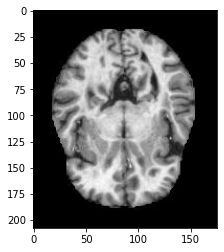

In [7]:
plt.imshow(np.moveaxis(train_imgs[0], 0, -1))

In [8]:
train_imgs[0]

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

In [9]:
train_imgs = torch.tensor(np.array(train_imgs), dtype=torch.float32)
train_labels = torch.tensor(np.array(train_labels), dtype=torch.long)

test_imgs = torch.tensor(np.array(test_imgs), dtype=torch.float32)
test_labels = torch.tensor(np.array(test_labels), dtype=torch.long)

In [10]:
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(train_imgs, train_labels)
test_dataset = TensorDataset(test_imgs, test_labels)

In [11]:
from torch.utils.data.sampler import SubsetRandomSampler
ntotal = len(train_imgs)
ntrain = int(ntotal*0.7)
nval = ntotal - ntrain

train_ix = np.random.choice(range(ntotal), size=ntrain, replace=False)
val_ix = list(set(range(ntotal)) - set(train_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)

In [12]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size, val_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle = True)

In [13]:
class alz_network(nn.Module):
    def __init__(self):
        super(alz_network, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Dropout2d(p=0.1),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=64*13*11,out_features=4,bias=True)
        )
    def forward(self, x):
        return self.layers(x)

In [14]:
model = alz_network()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [15]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

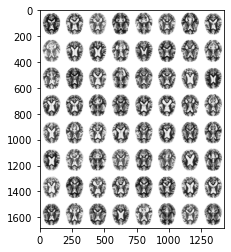

In [16]:
from torch.utils.tensorboard import SummaryWriter
import torchvision
import tensorflow_io as tfio

writer = SummaryWriter()

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.float()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

In [20]:
writer.add_graph(model, images.to(device))

In [21]:
writer.close()

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=100):
    train_loss = []
    val_loss = []
    test_acc = []
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            train_loss.append(total_loss)
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                val_loss.append(total_loss)
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            with torch.no_grad():
                total, correct = 0,0
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    predicted = torch.max(outputs, 1)[1]
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                acc = correct / total * 100
                print(f'test accuracy: {acc}')
                test_acc.append(acc)
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return train_loss, val_loss, test_acc

def test_network(model, test_loader, mode):
    true, pred = [], []
    with torch.no_grad():
        for inputs, labels  in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = torch.max(outputs,1)[1] # get predicted class label for each test example.
            # total += labels.size(0)
            # correct += (predicted == labels).sum().item()
            true.append(labels.cpu())
            pred.append(predicted.cpu())
    true = np.concatenate(true, dtype=np.float32)
    pred = np.concatenate(pred, dtype=np.float32)
    acc = (true == pred).sum() * 100 / true.size
    print('%s accuracy: %0.3f' % (mode, acc))
    # true = np.concatenate(true)
    # pred = np.concatenate(pred)
    return acc, true, pred

In [ ]:
d,e,f = train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=40)
acc, true, pred = test_network(model, test_loader, 'model')

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true, pred))

In [ ]:
acc, true, pred = test_network(model, train_loader, 'model')

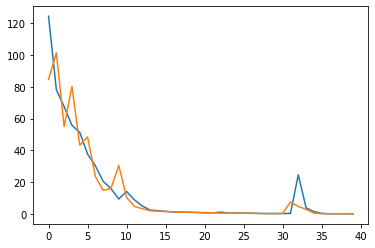

In [21]:
plt.plot(a)
plt.plot(b)

In [26]:
from torchvision import models

resnet = models.resnet18(pretrained=True)
#for parameter in resnet.parameters():
#    parameter.requires_grad = False
n_ftrs = resnet.fc.in_features
#resnet.conv1 = nn.Conv2d(1,64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
resnet.fc = nn.Linear(n_ftrs, 4)
resnet.to(device)

resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=1e-4, momentum=0.9)

In [28]:
a,b,c = train_network(resnet, train_loader, val_loader, criterion, optimizer, nepoch=40)

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.04483
   Val loss: 0.97376
test accuracy: 55.98123534010946

EPOCH 1
 Train loss: 0.93497
   Val loss: 0.90362
test accuracy: 57.07584050039093

EPOCH 2
 Train loss: 0.90047
   Val loss: 0.90844
test accuracy: 54.182955433932754

EPOCH 3
 Train loss: 0.85181
   Val loss: 0.90410
test accuracy: 52.462861610633304

EPOCH 4
 Train loss: 0.80081
   Val loss: 0.79418
test accuracy: 61.84519155590304

EPOCH 5
 Train loss: 0.77166
   Val loss: 0.98924
test accuracy: 52.931978107896796

EPOCH 6
 Train loss: 0.76544
   Val loss: 0.76336
test accuracy: 59.9687255668491

EPOCH 7
 Train loss: 0.72230
   Val loss: 1.18350
test accuracy: 40.344018764659886

EPOCH 8
 Train loss: 0.71194
   Val loss: 0.65264
test accuracy: 62.47068021892104

EPOCH 9
 Train loss: 0.64894
   Val loss: 0.80347
test accuracy: 58.79593432369038

EPOCH 10
 Train loss: 0.63095
   Val loss: 1.52790
test accuracy: 50.742767787333854

EPOCH 11
 Train loss: 0.85213
   Val loss: 0.66322
test accuracy: 62.70

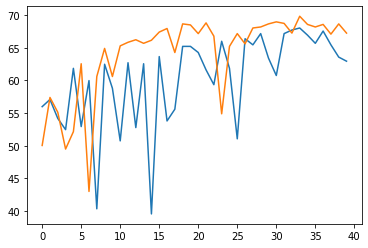

In [34]:
plt.plot

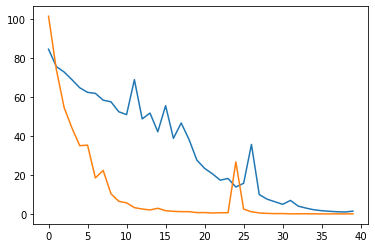

In [35]:
plt.plot(a)
plt.plot(d)

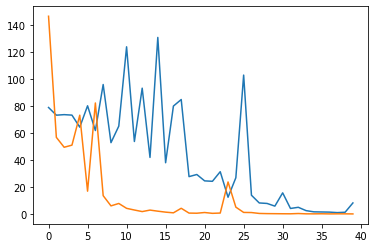

In [36]:
plt.plot(b)
plt.plot(e)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true, pred))